$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
\newcommand{\Cat}{\mathrm{Cat}}
\newcommand{\Bin}{\mathrm{Bin}}
$$

In [3]:
from __future__ import division

# scientific
%matplotlib inline
from matplotlib import pyplot as plt;
import numpy as np;
import sklearn as skl;
import sklearn.datasets;
import sklearn.cluster;

# ipython
import IPython;

# python
import os;

#####################################################

# image processing
import PIL;

# trim and scale images
def trim(im, percent=100):
    print("trim:", percent);
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100, (x.size[1]*percent)//100), PIL.Image.ANTIALIAS);


#####################################################

# daft (rendering PGMs)
import daft;

# set to FALSE to load PGMs from static images
RENDER_PGMS = True;

# decorator for pgm rendering
def pgm_render(pgm_func):
    def render_func(path, percent=100, render=None, *args, **kwargs):
        print("render_func:", percent);
        # render
        render = render if (render is not None) else RENDER_PGMS;
        
        if render:
            print("rendering");
            # render
            pgm = pgm_func(*args, **kwargs);
            pgm.render();
            pgm.figure.savefig(path, dpi=300);
            
            # trim
            img = trim(PIL.Image.open(path), percent);
            img.save(path, 'PNG');
        else:
            print("not rendering");
        
        # error
        if not os.path.isfile(path):
            raise Exception("Error:  Graphical model image %s not found.  You may need to set RENDER_PGMS=True." % path);
        
        # display
        return IPython.display.Image(filename=path);#trim(PIL.Image.open(path), percent);
    
    return render_func;

######################################################

# EECS 545:  Machine Learning

## Lecture 15:  Clustering, Mixture Models, and EM

- Instructor:  **Jacob Abernethy**
- Date:  March 14, 2016

*Lecture Exposition:*  Saket & Ben

# This lecture has notes!

> See Canvas / GitHub

## References

- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://research.microsoft.com/en-us/um/people/cmbishop/prml/).  2006.
- **[Koller & Friedman 2009]** Koller, Daphne and Nir Friedman.  [*Probabilistic Graphical Models*](https://mitpress.mit.edu/books/probabilistic-graphical-models).  2009.
- **[Neal 1998]** Neal, Radford and Geoffrey Hinton.  ["A View of the EM Algorithm that Justifies Incremental, Sparse, and Other Variants"](http://www.cs.toronto.edu/~fritz/absps/emk.pdf).  1998.
- **[Do 2008]** Do, Chuong B. and Serafim Batzoglou.  ["What is the Expectation Maximization Algorithm?"](http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html). 2008.

## Outline

- Clustering & Mixture Models
    - Latent Variable Models
    - Gaussian Mixture Models
- Review:  Information Theory
- Expectation Maximization
    - Evidence Lower Bound
    - Variational Approximation
- Examples
    - Coin Flip Example
    - Gaussian Mixture Models

# Clustering & Mixture Models

> Uses material from **[MLAPP]**

### Review:  Latent Variable Models

In a **Latent Variable Model**, we have
- Observed variables $X$
- Hidden variables $Z$ that influence $X$
- Parameters $\theta$ governing the overall model

In general, our goal is to
> Use what we know to make *inferences* about what we don't know.

### Review:  Latent Variable Models

The most general latent variable model for iid observations $\X$ is
- $X_n$ and $Z_n$ may be sets of variables
- Parameters $\theta$ can be divided into variables $\theta_x$ influencing $X$ and $\theta_z$ influencing $Z$

In [9]:
@pgm_render
def pgm_latent():
    pgm = daft.PGM([4,4], origin=[-2,-1], node_unit=0.8, grid_unit=2.0);
    # nodes
    pgm.add_node(daft.Node("z", r"$Z_n$", 0.7, 1));
    pgm.add_node(daft.Node("x", r"$X_n$", 1.3, 1, observed=True));
    pgm.add_node(daft.Node("theta", r"$\theta$", 1.3, 0.3));
    
    # edges
    pgm.add_edge("z", "x", head_length=0.08);
    pgm.add_edge("theta", "x", head_length=0.08);
    pgm.add_edge("theta", "z", head_length=0.08);
    
    pgm.add_plate(daft.Plate([0.4,0.8,1.3,0.5], label=r"$\qquad\qquad\qquad\;\; N$",
    shift=-0.1))
    
    return pgm;

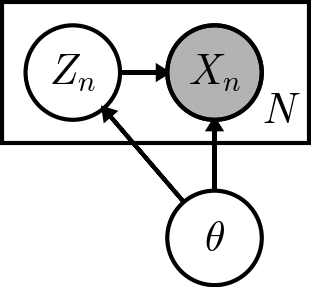

In [10]:
%%capture
pgm_latent("images/pgm/latent.png")

### Review:  Clustering

**Goal:** Partition data $\X = \{ x_1, \dots, x_n \} \subset \R^d$ into $K$ disjoint **clusters**.
- Points within a cluster should be more similar to each other than to points in other clusters.
- Estimate **cluster centers** $\mu_k \in \R^d$ for $k=1,\dots,K$
- Estimate **cluster assignments** $z_j \in \{1,\dots,K\}$ for each point $x_j$

Usually, we fix $K$ beforehand!  Use model selection to overcome this limitation.

### Review:  K-Means Clustering

First, pick random cluster centers $\mu_k$.  Then, repeat until convergence:

<div style="margin:10px; padding: 10px; border: 2px solid black">
**E-Step:** Assign $x_j$ to the nearest cluster center $\mu_k$,
$$
z_j = \arg\min_k || x_j - \mu_k ||^2
$$

**M-Step:** Re-estimate cluster centers by averaging over assignments:
$$
\mu_k = \frac{1}{ \# \{ j \mid z_j =k \}} \sum_{j=1}^N x_j \mathbb{I}(z_j = k)
$$
</div>

### Mixture Models

Clustering problems motivate the definition of a **mixture model**.
- Observe data from multiple **base distributions** $p_k(x|\theta_k)$ over the same space.
- Proportion of each distribution given by **mixing weights** $\pi = (\pi_1,\dots,\pi_K)$
- Don't know *which* distribution each point comes from.

$$
p(x | \theta) = \sum_{k=1}^K \pi_k p_k(x | \theta_k)
$$

### Mixture Models for Clustering

In clustering, we represent mixtures via latent **cluster indicators**,
$$
\begin{align}
z_n &\sim \Cat[\pi] & \forall\, n = 1,\dots,N \\
x_n \mid z_n &\sim p_k(\cdot \mid \theta_{z_n}) & \forall\, n = 1,\dots,N
\end{align}
$$

In this form, mixture models are clearly applicable to clustering problems.

> For a deeper understanding of mixture models, see [De Finetti's Theorem](http://www.cs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture1.pdf).

### Gaussian Mixture Models

In a **Gaussian Mixture Model**, the base distributions are Gaussian.
- Cluster $k$ has mean $\mu_k$, covariance $\Sigma_k$

$$
\begin{align}
z_n &\sim \Cat[\pi] & \forall\, n = 1,\dots,N \\
x_n \mid z_n &\sim \mathcal{N}(\mu_{z_n}, \Sigma_{z_n}) & \forall\, n = 1,\dots,N
\end{align}
$$


### <span style="color:red">Gaussian Mixture Models:  Visualization</span>

Here are the contours of each base distribution plotted together:

### <span style="color:red">Gaussian Mixture Models:  Visualization</span>

Below is a plot of the resulting mixture density:

### Gaussian Mixture Models:  Inference & Learning

**Goal:** Since only the data points $x_n$ are observed, we wish to
1. Learn the cluster parameters $\mu$, $\Sigma$
2. Infer the cluster assignments $z_n$ for each point $x_n$

We will use the **Expectation Maximization** algorithm.
- Same general idea as K-means, but *fuzzier* (probabilistic!)
- Alternate between *guessing* latent variables and *re-estimating* parameters.

# Review of Information Theory
> See **Lecture 13** or **[MLAPP]** §2.8 for more details.

### Review:  Entropy

The **entropy** of a discrete random variable $X$ with distribution $p$ is
$$
H[X] = H[p] = E[I(p(X))] = - \sum_{x \in X} p(x) \log p(x)
$$

Entropy measures the **optimal code length**, in bits, for messages drawn from $p$.
- Expected information received when sampling from $X$.

### Review:  Cross Entropy

The **cross entropy** measures the average number of bits needed to encode messages drawn from $p$ when we use a code optimal for $q$:
$$
H(p,q) = -\sum_{x \in \X} p(x) \log q(x)
= - E_p[\log q(x)]
$$

Intuitively, $H(p,q) \geq H(p)$.  The **relative entropy** is the difference $H(p,q) - H(p)$.

### Review:  Relative Entropy

The **relative entropy** or **Kullback-Leibler divergence** of $q$ from $p$ is

$$
\begin{align}
D_{KL}(p || q)
&= \sum_{x \in X} p(x) \log \frac{p(x)}{q(x)} \\
&= H(p,q) - H(p)
\end{align}
$$

> Measures the number of *extra* bits needed to encode messages from $p$ if we use a code optimal for $q$.

# Expectation Maximization

> Uses material from **[Neal 1998]**, **[Do 2008]**, and **[MLAPP]**

### Theoretical Perspective

Most textbooks (including **[MLAPP]** and **[PRML]**) introduce EM without much justification.
- This is confusing and unsatisfying!

Instead, we will tackle the theory head-on, using ideas from **[Neal 1998]**.

> **Question:** How can we perform maximum likelihood estimation in latent variable models?

### Parameter Estimation with Latent Variables

> **Question:**  How can we perform MLE/MAP in latent variable models?

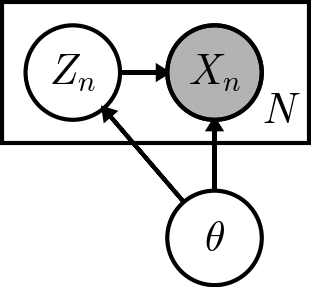

In [11]:
%%capture
pgm_latent("images/pgm/latent.png")

### Complete Data Log-Likelihood

Suppose we observe both $X$ and $Z$.  The **complete data log-likelihood** is
$$
\ell_c(\theta)
= \sum_{n=1}^N \log p(x_n, z_n | \theta)
$$

> **[MLAPP]:** This likelihood function is convex when $p(x_n,z_n | \theta)$ is an exponential family distribution.

### Observed Data Log-Likelihood

In reality, we only observe $\X=(x_1,\dots,x_n)$.  The **observed data log-likelihood** is given by 
$$
\begin{align}
\ell(\theta | \X) 
&= \log p(\X | \theta)
= \sum_{k=1}^N \log p(x_k | \theta) \\
&= \sum_{k=1}^N \left[ \log \sum_{z} p(x_k, z | \theta) \right]
\end{align}
$$

> **[MLAPP]:** This likelihood function is **non-convex** even assuming exponential family distributions.  Multiple modes make inference (NP) hard!

### Wrangling a Non-Convex Likelihood

How can we optimize the observed likelihood $\ell(\theta|\X)$?
- *Gradient-based methods?* Tricky to enforce constraints (e.g. positive-definiteness)

**Observation:** In most models, MLE/MAP is easy with fully observed data.  We will alternate between
1. Inferring the values of the latent variables.
2. Re-estimating the parameters, assuming we have complete data.

> Note the similarity to K-Means!

### Optimizing via Lower-Bounds

From a theoretical standpoint, we will alternate between
1. Estimating a lower bound $\L(q,\theta)$ on the log-likelihood $\log p(\X|\theta)$
2. Maximizing this lower bound to obtain a new estimate of $\theta$

<img src="images/bishop-fig914-em-bound.png">
<span style="color: gray">(Figure 9.14 of **[PRML]**)</span>

### Expectation Maximization

Our general approach will be to reason about the hidden variables through a proxy distribution $q(Z)$.
- Distribution $q$ is an approximation to $P(Z | \X, \theta)$
- We use $q$ to compute a lower bound on the log-likelihood.

> The $q$ distribution will disappear later, but this perspective is useful for extending EM to new settings.

### <span style="color:red">Review:  Jensen's Inequality</span>

### Evidence Lower Bound

Through Jensen's inequality, we obtain the **evidence lower bound (ELBO)** on the log-likelihood:
$$
\begin{align}
\ell(\theta | \X)
&= \log \sum_z p(\X, z | \theta) \\
&= \log \sum_z q(z) \frac{p(\X, z | \theta)}{q(z)} \\
&\geq \sum_z q(z) \ln \frac{p(\X, z | \theta)}{q(z)} \equiv \L(q, \theta)
\end{align}
$$

### Evidence Lower Bound

We can rewrite the lower bound $\L(q, \theta)$ as follows:
$$
\begin{align}
\ell(\theta | \X)
\geq \L(q,\theta)
&= \sum_z q(z) \log \frac{p(\X,z|\theta)}{q(z)} \\
&= \sum_q q(z) \log p(\X,z|\theta) - \sum_z q(z) \log q(z) \\
&= E_q[\log p(\X,Z|\theta)] - E_q[\log q(z)] \\
&= E_q[\log p(\X,Z|\theta)] + H[q]
\end{align}
$$

### ELBO:  Relationship to Relative Entropy

We have just shown that
$$
\ell(\theta|\X) \geq \L(q,\theta)
= E_q[\log p(\X,Z|\theta)] - E_q[\log q(z)]
$$

This very closely resembles the formula for **relative entropy** 
$$
\begin{align}
D_{KL}(q || p) 
&= E_q[-\log p(Z)] + E_q[\log q(Z)] \\
&= H[q,p] - H[q]
\end{align}
$$

Except that the variables $X$ are clamped to our observations $X=\X$.
- So $P(\X,Z)$ is an *unnormalized* distribution.

### ELBO:  Relationship to Relative Entropy

It is easy to show $\L(q,\theta)$ differs from a relative entropy by only a constant wrt $\theta$:
$$
\begin{align*}
D_{KL}(q || p(Z|\X,\theta))
&= H(q, p(Z|\X,\theta)) - H(q) \\
&= E_q[ -\log p(Z|\X,\theta) ] - H(q) \\
&= E_q[ -\log p(Z,\X | \theta) ] - E_q[ -\log p(\X|\theta) ] - H(q) \\
&= E_q[ -\log p(Z,\X | \theta) ] + \log p(\X|\theta) - H(q) \\
&= -\mathcal{L}(q,\theta) + \mathrm{const.}
\end{align*}
$$

### ELBO:  Tightness

This yields a second proof of the ELBO, following from the nonnegativity of relative entropy.
$$
\boxed{
\log p(\X | \theta)
= D_{KL}(q || p(Z | \X, \theta)) + \mathcal{L}(q,\theta) 
\geq \mathcal{L}(q,\theta)
}
$$

The quality of our bound $\L(q,\theta)$ depends heavily on the choice of proxy distribution $q(Z)$.

> **Remark:** Maximizing $\L(q, \theta)$ with respect to $q$ is equivalent to minimizing the relative entropy between $q$ and the hidden posterior $P(Z|\X,\theta)$.  Hence, the optimal $q$ is exactly the hidden posterior, for which $\log p(\X|\theta) = \L(q,\theta)$.

The bound is **tight**--we can make it *touch* the log-likelihood.

### Expectation Maximization

Finding a global maximum of the likelihood is difficult in the presence of latent variables.
$$
\hat\theta_{ML} = \arg\max_\theta \ell(\theta | \X) = \arg\max_\theta \log p(\X|\theta)
$$

Instead, the **Expectation Maximization** algorithm gives an iterative procedure for finding a *local* maximum of the likelihood.
- Under the assumption that the hidden posterior $P(Z|\X,\theta)$ is tractable.
- Exploits the evidence lower bound $\ell(\theta|\X) \geq \L(q,\theta)$.

### Expectation Maximization

Consider only proxy distributions of the form
$$
q_\vartheta(Z) = p(Z | \X, \vartheta)
$$

The optimal value for $\vartheta$, in the sense that $\L(\vartheta, \theta) \equiv \L(q_\vartheta, \theta)$ is maximum, depends on $\theta$.
- Similarly, the optimal $\theta$ depends on $\vartheta$.

This suggests an *iterative* scheme.

### Expectation Maximization:  E-Step

Suppose we have an estimate $\theta_t$ of the parameters.  To improve our estimate, we first compute a new lower bound on the observed log-likelihood,
$$
\vartheta_{t+1}
= \arg\max_\vartheta \L(\vartheta, \theta_t)
= \theta_t
$$

Since $q_\vartheta(Z) = p(Z|\X,\vartheta)$, we know from before that $\vartheta=\theta_t$ maximizes $\L(\vartheta, \theta)$.

### Expectation Maximization:  M-Step

Next, we estimate new parameters by optimizing over the lower bound.
$$
\begin{align}
\theta_{t+1}
&= \arg\max_\theta \L(\vartheta_{t+1}, \theta) \\
&= \arg\max_\theta E_q[\log p(\X,Z|\theta)] - E_q[\log q_\vartheta(z)] \\
&= \arg\max_\theta E_q[ \log p(\X,Z | \theta) ]
\end{align}
$$

The last line optimizes over the **expected complete data log-likelihood**.

### Expectation Maximization:  Algorithm

Expectation maximization performs **coordinate ascent** on $\L(\vartheta,\theta)$.

<div style="margin:10px;padding:10px;border:2px solid black;">
<div>
**E-Step:** Compute a new lower bound on the observed log-likelihood,
    $$
    \vartheta_{t+1} 
    = \arg\max_\vartheta \L(\vartheta, \theta_t)
    = \theta_t
    $$
</div><div>
**M-Step:** Estimate new parameters by optimizing over the lower bound.
    $$
    \theta_{t+1}
    = \arg\max_\theta \L(\vartheta_{t+1}, \theta)
    = \arg\max_\theta E_q[ \log p(\X,Z | \theta) ]
    $$
</div>
</div>

### Expectation Maximization:  Standard Formulation

Some authors define the **auxiliary function** or **Q-function**
$$
Q(\theta_t, \theta) = E_q[\log p(\X,Z|\theta)]
$$
where $q(Z) = p(Z|\X,\theta_t)$ as before.

> Some forgo the $q$ function altogether!

### Expectation Maximization:  Standard Formulation

Expectation maximization performs updates on $Q(\theta_t,\theta)$.

<div style="margin:10px;padding:10px;border:2px solid black;">
<div>
**E-Step:** Write down an expression for 
    $$
    Q(\theta_t, \theta) = E_q[ \log p(\X,Z | \theta) ]
    $$
</div><div>
**M-Step:** Estimate new parameters by optimizing the auxiliary function,
    $$
    \theta_{t+1}
    = \arg\max_\theta Q(\theta_t, \theta)
    $$
</div>
</div>

### Expectation Maximization:  Summary



# DAFT

In [16]:
@pgm_render
def pgm_coinflip():
    pgm = daft.PGM([4,4], origin=[-2,-1], node_unit=0.8, grid_unit=2.0);
    # nodes
    pgm.add_node(daft.Node("z", r"$Z_n$", 0.7, 1));
    pgm.add_node(daft.Node("x", r"$X_n$", 1.3, 1, observed=True));
    pgm.add_node(daft.Node("theta", r"$\theta$", 1.3, 0.3));
    
    # edges
    pgm.add_edge("z", "x", head_length=0.08);
    pgm.add_edge("theta", "x", head_length=0.08);
    
    pgm.add_plate(daft.Plate([0.4,0.8,1.3,0.5], 
                             label=r"$\qquad\qquad\qquad\;\; N$",
                             shift=-0.1))
    return pgm;

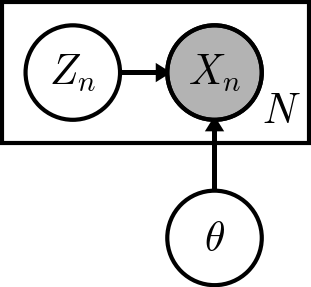

In [17]:
%%capture
pgm_coinflip("images/pgm/coinflip.png")